In [19]:
import random
import numpy as np
from random import shuffle
from numpy import matlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cvxpy as cp
class DictionaryLearning(object):
    def __init__(self,Y):
        self.Y = Y
        self.Y_reg=None #selected columns for new data matrix Y_new
        self.C=None #coefficient matrix
           
class SubsetSelection(object):
    def __init__(self, Y,dist, reg):
        self.dist = dist
        self.Y=Y
        self.reg =reg
        self.N = len(self.dist)
    def ADMM_SparseModeling_bycvxpy(self, mu, p=np.inf,outlier=False,select_num=10,flag=True):
        Y=self.Y.T
        # 定义优化变量C
        [M, N] = np.shape(Y)
        C = cp.Variable((N, N))

        # 定义两个约束
        constraint1 = cp.sum(C,axis=0) == 1
        constraint2=C>=0
        # 将约束放入 constraints 列表
        constraints = [constraint1,constraint2]

        # 构建目标函数
        obj = cp.Minimize(self.reg * cp.norm(C, "fro") + 0.5 * cp.norm(Y - Y @ C, "fro"))

        # 创建问题实例
        problem = cp.Problem(obj, constraints)

        # 使用ADMM求解器
        problem.solve(solver=cp.SCS, verbose=True)
        # 获取最小值
        result = problem.value   
        [M,N]=np.array(C.value).shape
        norms = np.zeros(N)  # 存储列向量的q范数
        indices = np.arange(N)  # 列向量的索引
        top_k_indices = []  # 选择的列向量的索引
        for j in range(N):
            norms[j] = np.linalg.norm(C.value[:, j], ord=p)
            if norms[j]>0.3:
                top_k_indices.append(j)
            #print("范数，根据范数从小到大选择",norms[j])
        # 根据列向量的q范数排序
        sorted_indices = np.argsort(norms)[::-1]
        # 选择排序后的前k个向量的索引
        top_k_indices1 = sorted_indices[:int(len(norms)*0.4)]
        ret = {
             'C': C.value, 'selected': top_k_indices,'selected1':top_k_indices1,'target':result
        }
        return ret,C.value
    def ADMM_SparseModeling(self, mu, epsilon, max_iter, p=np.inf,outlier=False,select_num=10,flag=True):
        """
        :param mu:        penalty parameter.
        :param epsilon:   small value to check for convergence.
        :param max_iter:  maximum number of iterations to run this algorithm.
        :param p:         norm to be used, only support np.inf currently.
        :param outlier:   support detecting outliers
        :returns: representative of the data, total number of representatives, and the objective function value.
        """
        # initialize the ADMM solver.
        G = ADMM(mu, epsilon, max_iter, self.reg)
        # run the ADMM algorithm.
        #print(self.Y.shape)
        k, Z = G.runADMM_SparseModeling(self.Y, p, outlier,mu, epsilon, max_iter,flag)
        frobenius_norm = 0.5*np.linalg.norm(self.Y.T-self.Y.T@Z, ord='fro')+self.reg*np.linalg.norm(Z, ord='fro')
        '''
        print(k,frobenius_norm)
        count=0
        for i in range(100000):
            Z1=add_small_bias(Z,0.01)
            frobenius_norm1 = np.linalg.norm(self.Y.T-self.Y.T@Z1, ord='fro')+np.linalg.norm(Z1, ord='fro')
            if frobenius_norm1 < frobenius_norm:
                count+=1
                print(frobenius_norm1< frobenius_norm, frobenius_norm1, frobenius_norm)
        print("错误率：",count/100000)'''
        # find the index and total count of the representatives, given the representative matrix.
        [M,N]=np.array(Z).shape
        norms = np.zeros(N)  # 存储列向量的q范数
        indices = np.arange(N)  # 列向量的索引
        top_k_indices = []  # 选择的列向量的索引
        for j in range(N):
            norms[j] = np.linalg.norm(Z[:, j], ord=p)
            if norms[j]>0.3:
                top_k_indices.append(j)
            #print("范数，根据范数从小到大选择",norms[j])
       #print(norms)
        # 根据列向量的q范数排序
        sorted_indices = np.argsort(norms)[::-1]
        # 选择排序后的前k个向量的索引
        top_k_indices1 = sorted_indices[:int(len(norms)*0.4)]
        count = 0
        ret = {
            'k': k, 'Z': Z, 'selected': top_k_indices,'selected1':top_k_indices1,'target':frobenius_norm
        }
        return ret
    def ADMM(self, mu, epsilon, max_iter, p=np.inf, prefer_row=[], prefer_coef_shrink=0, rows_coef=None, cooperation=None, outlier=False, beta=np.inf, tau=np.inf):
            """
            :param mu:        penalty parameter.
            :param epsilon:   small value to check for convergence.
            :param max_iter:  maximum number of iterations to run this algorithm.
            :param p:         norm to be used, only support np.inf currently.
            :param prefer_row: the rows that users prefer
            :param prefer_coef_shrink: the multiplied coefficient for the rows that users prefer. 1 means no preference.
            < 1 means prefer to select (0 means must select), > 1 means prefer not to select
            :param rows_coef: prior for row selection. By default is None, which means all coef are 1
            :param cooperation: the cross term of the rows
            :param outlier: support detecting outliers
            :returns: representative of the data, total number of representatives, and the objective function value.
            """

            # initialize the ADMM solver.
            G = ADMM(mu, epsilon, max_iter, self.reg)

            # run the ADMM algorithm.
            k, Z = G.runADMM(self.dist, p, prefer_row, prefer_coef_shrink, rows_coef, cooperation, outlier, beta, tau)
            if outlier: 
                Z, outlier_Z = Z[:-1,:], Z[-1,:]#Z矩阵的最后一行是outlier_Z？？？
                outliers = np.where(outlier_Z > 0.1)[0].tolist()
            frobenius_norm = 0.5*np.linalg.norm(self.Y.T-self.Y.T@Z, ord='fro')+mu *np.linalg.norm(Z, ord='fro')
            # find the index and total count of the representatives, given the representative matrix.
            selected = []
            count = 0
            for i in range(len(Z)):
                flag = 0
                for j in range(np.array(Z).shape[1]):
                    if outlier and j in outliers: continue
                    if Z[i, j] > 0.1:#如果Z矩阵元素大于0.1则选择？？？
                        flag = 1
                        count += 1
                if flag == 1:
                    selected.append(i)

            ret = {
                'k': k, 'Z': Z, 'selected': selected,'target':frobenius_norm
            }
            if outlier:
                ret['outlier_Z'] = outlier_Z
                ret['outliers'] = outliers
            return ret



class ADMM(object):
    """
        :param mu:        penalty parameter.
        :param epsilon:   small value to check for convergence.
        :param max_iter:  maximum number of iterations to run this algorithm.
        :param reg:       regularization parameter.
    """
    def __init__(self, mu, epsilon, max_iter, reg):
        self.mu = mu
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.reg = reg
    def runADMM(self, dis_matrix, p, prefer_row, prefer_coef_shrink, rows_coef, cooperation, outlier, beta, tau):
        """
        This function solves the proposed trace minimization regularized by row-sparsity norm using an ADMM framework
        To know more about this, please read :
        Dissimilarity-based Sparse Subset Selection
        by Ehsan Elhamifar, Guillermo Sapiro, and S. Shankar Sastry
        https://arxiv.org/pdf/1407.6810.pdf
        :param dis_matrix:      dissimilarity matrix.
        :param p:               norm of the mixed L1/Lp regularizer, {2,inf}
        :param previous_penalized will be multiplied to prefer_row uniformly
        :returns:               representative matrix for te dataset.
        """
        if outlier:
            [M, N] = np.shape(dis_matrix)
            _dis_matrix = np.array(dis_matrix)
            dis_matrix = np.zeros((M+1, N))
            dis_matrix[:M, :] = _dis_matrix
            for j in range(N):
                dis_matrix[M,j] = (self.reg / beta) * np.exp(-_dis_matrix[:,j].min() / tau)
            prefer_row.append(M)
        
        if rows_coef is None: rows_coef = np.ones(len(dis_matrix))

        [M, N] = np.shape(dis_matrix)
        k = 1

        # calculate te centroid point of te dataset.
        C1 = np.zeros((np.shape(dis_matrix)))#C1是全0阵
        idx = np.argmin(np.sum(dis_matrix, axis=1))#找到dis_matrix每一行的最小值，返回索引
        C1[idx, :] = 1#将最小值所在的行全置为1，其他行全置为0

        # regularization coefficient matrix.
        Lambda = np.zeros((M, N))
        CFD = np.ones((M, 1)) * (self.reg / self.mu) * rows_coef.reshape(-1,1)
        for i in prefer_row: CFD[i] *= prefer_coef_shrink
        iterations=[]#添加迭代次数
        error1_values = []  # 添加error1的值
        error2_values = []  # 添加error2的值
        true_loss_values = []  # 添加真实loss的值
        true_loss_Z=[]
        while True:#C2=C^k+1,C=C^k,Lambda=Lambda^k,Z=Z^k+1
            # perform the iterative ADMM steps for two variables.
            if cooperation is not None:
                Z = self.solverLpshrinkCooperation(C1 - np.divide((Lambda), self.mu), CFD, p, cooperation)
            else:
                Z = self.solverLpshrink(C1 - np.divide((Lambda), self.mu), CFD, p)
            C2 = self.solverBCLSclosedForm(Z + np.divide(Lambda - dis_matrix, self.mu))#解决C^k+1=argmin||C-(Z^{k+1}+D*Lambda^k/mu)||_F^2
            Lambda = Lambda + np.multiply(self.mu, (Z - C2))

            # calculate the error from previous iteration.
            err1 = self.errorCoef(Z, C2)
            err2 = self.errorCoef(C1, C2)
            # if error is less then epsilon then return the current representative matrix.
            if k >= self.max_iter or (err1 <= self.epsilon and err2 <= self.epsilon): break
            iterations.append(k)
            k += 1
            C1 = C2
            error1_values.append(err1)
            error2_values.append(err2)
            true_loss_values.append(self.reg*C2.max(axis=1).sum() + np.sum(dis_matrix*C2))
            true_loss_Z.append(self.reg*Z.max(axis=1).sum() +np.sum(dis_matrix*Z))
        '''print(len(iterations))
        plt.figure() 
        true_loss_values[0]=true_loss_values[1]
        # 绘制损失值、error1、error2和真实loss随迭代轮次变化的折线图
        plt.plot(iterations, error1_values, label='Error1')
        plt.plot(iterations, error2_values, label='Error2')
        plt.plot(iterations, true_loss_values, label='True Loss')
        plt.plot(iterations, true_loss_Z, label='True Loss Z')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Loss and Errors vs. Iteration')
        plt.grid(True)
        plt.legend()
        plt.show()'''
        Z = C2

        return k, Z
    @staticmethod
    def solve_hard_constraint(C, tau):
        """
        This function solves the optimization program of
                    min ||C-Z||_F^2  s.t.  |Z|_{1,inf} <= tau
        :param C:      variable of the optimization.
        :param tau:    constraints
        :returns:      MxN coefficient matrix.
        """
        epsilon = 1e-4
        C_abs = np.sort(np.absolute(C), axis=1)
        M, N = C.shape
        tau_rows = np.zeros(M)
        grad_rows = C_abs.sum(axis=1)
        while tau > epsilon and np.sum(grad_rows) > epsilon:                  
            cnt_rows = (C_abs < epsilon).sum(axis=1)
            grad_rows = C_abs.sum(axis=1)
            next_steps = np.zeros(M)
            max_grad = grad_rows.max()
            max_grad_idx = [i for i in range(M) if grad_rows[i] > max_grad - epsilon]
            delta_grad = 1e4
            for r in max_grad_idx:
                if cnt_rows[r] < N:
                    delta_grad = min(delta_grad, C_abs[r, cnt_rows[r]] * (N - cnt_rows[r]))
            if len(max_grad_idx) < M:
                second_large_grad = np.max([grad_rows[i] for i in range(M) if i not in max_grad_idx])
                delta_grad = min(delta_grad, max_grad - second_large_grad)
            delta_tau = [delta_grad / (N - cnt_rows[r]) if cnt_rows[r] < N else 0 for r in max_grad_idx]
            delta_tau_sum = np.sum(delta_tau)
            if delta_tau_sum > tau:
                coef = tau / delta_tau_sum
                delta_tau = [x * coef for x in delta_tau]
                delta_tau_sum = tau
            
            tau -= delta_tau_sum
            for i, r in enumerate(max_grad_idx):
                tau_rows[r] += delta_tau[i]
                C_abs[r] -= delta_tau[i]
                C_abs[r][C_abs[r]<0] = 0

        Z = np.zeros(C.shape)
        for i in range(M):
            Z[i] = np.clip(C[i], -tau_rows[i], tau_rows[i])
        return Z

    @staticmethod
    def shrinkL2Linf(y, t):
        """
        This function minimizes
                0.5*||b*x-y||_2^2 + t*||x||_inf, where b is a scalar.
        Note that it suffices to consider the minimization
                0.5*||x-y||_2^2 + t/b*||x||_inf
        the value of b can be assumed to be absorbed into t (= tau).
        The minimization proceeds by initializing x with y.  Let z be y re-ordered so that the abs(z) is in
        descending order. Then first solve
                min_{b>=abs(z2)} 0.5*(b-abs(z1))^2 + t*b
        if b* = abs(z2), then repeat with first and second largest z values;
                min_{b>=abs(z3)} 0.5*(b-abs(z1))^2+0.5*(b-abs(z2))^2 + t*b
        which by expanding the square is equivalent to
                min_{b>=abs(z3)} 0.5*(b-mean(abs(z1),abs(z2)))^2 + t*b
        and repeat this process if b*=abs(z3), etc.
        This reduces problem to finding a cut-off index, where all coordinates are shrunk up to and
        including that of the cut-off index.  The cut-off index is the smallest integer k such that
               1/k sum(abs(z(1)),...,abs(z(k))) - t/k <= abs(z(k+1))
        :param y:       variable of the above optimization .
        :param t:       regualrization for the above optimization
        :returns:       row of MxN coefficient matrix.
        """

        x = np.array(y, dtype=np.float32)
        o = np.argsort(-np.absolute(y))
        z = y[o]

        # find the cut-off index
        cs = np.divide(np.cumsum(np.absolute(z[0:len(z) - 1])), (np.arange(1, len(z))).T) - \
             np.divide(t, np.arange(1, len(z)))
        d = np.greater(cs, np.absolute(z[1:len(z)])).astype(int)
        if np.sum(d, axis=0) == 0:
            cut_index = len(y)
        else:
            cut_index = np.min(np.where(d == 1)[0]) + 1

        # shrink coordinates 0 to cut_index - 1
        zbar = np.mean(np.absolute(z[0:cut_index]), axis=0)

        if cut_index < len(y):
            x[o[0:cut_index]] = np.sign(z[0:cut_index]) * max(zbar - t / cut_index, np.absolute(z[cut_index]))
        else:
            x[o[0:cut_index]] = np.sign(z[0:cut_index]) * max(zbar - t / cut_index, 0)

        return x
    #self.solverLpshrink(C1 - np.divide((Lambda), self.mu), CFD, p)
    @staticmethod
    def solverLpshrink(C1, l, p):
        """
        This function solves the shrinkage/thresholding problem for different norms p in {2, inf}
        :param C1:      variable of the optimization.
        :param l:       regualrization for the above optimization
        :param p:       norm used in the optimization
        :returns:       MxN coefficient matrix.
        """

        if len(l) > 0:
            [D, N] = np.shape(C1)

            if p == np.inf:
                C2 = np.zeros((D, N), dtype=np.float32)
                for i in range(D):
                    C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, l[i]).T
            elif p == 2:
                raise NotImplementedError
                r = np.maximum(np.sqrt(np.sum(np.power(C1, 2), axis=1, keepdims=True)) - l, 0)
                C2 = np.multiply(matlib.repmat(np.divide(r, (r + l)), 1, N), C1)
        return C2

    @staticmethod
    def solverLpshrinkCooperation(C1, l, p, cooperation):
        [D, N] = np.shape(C1)
        if p == np.inf:
            C2 = np.zeros((D, N), dtype=np.float32)
            for i in range(D):
                C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, l[i]).T
            for _ in range(10):
                for i in np.random.permutation(D):
                    new_coef = l[i] - np.sum([cooperation[i,j] * C2[j,:].max() for j in range(D)])
                    C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, new_coef).T
        else:
            raise NotImplementedError("unsupport p")
        return C2
    def solverBCLS_varieties1_byCvxpy(self,Y1, U, mu):
        # 定义优化变量C
        [M, N] = np.shape(U)
        C = cp.Variable((M, N))

        # 定义目标函数
        objective = cp.Minimize(0.5 * mu * cp.sum_squares(C - U) + 0.5 * cp.sum_squares(Y1 - Y1 @ C))

        # 定义约束条件
        constraints = [cp.sum(C, axis=0) == 1]

        # 定义优化问题
        problem = cp.Problem(objective, constraints)

        # 求解优化问题
        result = problem.solve()
        return result,C.value
    def solverBCLS_varieties1(self,Y1, U, mu): 
        """
        This function solves the optimization program of
                    min 0.5||Y-YC||_F^2+0.5*mu*||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
        :param U:      variable of the optimization.
        :param Y:      variable of the dataset.
        :param mu:     penaty for the above optimization
        :returns:      MxN coefficient matrix.
        """
        start = time.time()
        [M, N] = np.shape(U)
        coef_matrix = np.zeros((N*N+N,N*N+N), dtype=np.float32)
        b_matrix = np.zeros((N*N+N,1), dtype=np.float32)
        #N*N个方程，由L对cij求导得到
        for  i in range(N):
            for j in range(N):
                ##计算常数项
                # 提取第 i 列和第 j 列
                column_i = Y1[:, i]
                column_j = Y1[:, j]
                # 计算列的乘积
                result = np.dot(column_i, column_j)
                # 将乘积结果放入矩阵中
                b_matrix[i*N+j]=result+mu*U[i,j]
                ##计算系数矩阵
                row_coef = np.zeros(N*N+N, dtype=np.float32)
                for q in range(N):
                    for p in range(N):
                        if p!=j:
                            continue
                        column_k = Y1[:, q]
                        column_i1 = Y1[:, i]
                        result1 = np.dot(column_i1, column_k)
                        column_sum = np.sum(result1)
                        if q==i:
                            column_sum=column_sum+mu
                        row_coef[q*N+p]=column_sum
                for q in range(N):
                    if q!=j:
                        continue
                    row_coef[N*N+q]=1
                coef_matrix[i*N+j]=row_coef
        #N个约束条件
        for i in range(N):
            b_matrix[N*N+i]=1
            for j in range(N):
                coef_matrix[N*N+j][i*N+j]=1   
        print("time1",time.time()-start)
        start = time.time()
        x = np.linalg.solve(coef_matrix, b_matrix)
        print("time2",time.time()-start)
        # 将列表转换为N行N列的矩阵
        my_matrix = np.reshape(x[:N*N], (N, N))
        return my_matrix
  

    @staticmethod
    def solverBCLSclosedForm(U):
        """
        This function solves the optimization program of
                    min ||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
        :param U:      variable of the optimization.
        :returns:      MxN coefficient matrix.
        """
        
        [m, N] = np.shape(U)

        # make every row in decreasing order.
        V = np.flip(np.sort(U, axis=0), axis=0)

        # list to keep the hold of valid indices which requires updates.
        activeSet = np.arange(0, N)
        theta = np.zeros(N)
        i = 0

        # loop till there are valid indices present to be updated or all rows are done.
        while len(activeSet) > 0 and i < m:
            j = i + 1

            # returns 1 if operation results in negative value, else 0.
            idx = np.where((V[i, activeSet] - ((np.sum(V[0:j, activeSet], axis=0) - 1) / j)) <= 0, 1, 0)

            # find indices where the above operation is negative.
            s = np.where(idx == 1)[0]

            if len(s):
                theta[activeSet[s]] = 0 if j == 1 else (np.sum(V[0:i, activeSet[s]], axis=0) - 1) / (j - 1)

            # delete the indices which were updated this iteration.
            activeSet = np.delete(activeSet, s)
            i = i + 1

        if len(activeSet) > 0:

            theta[activeSet] = (np.sum(V[0:m, activeSet], axis=0) - 1) / m

        C = np.maximum((U - matlib.repmat(theta, m, 1)), 0)

        return C

    @staticmethod
    def errorCoef(Z, C):
        """
        This function computes the maximum error between elements of two coefficient matrices
        :param Z:       MxN coefficient matrix.
        :param C:       MxN coefficient matrix
        :returns:       infinite norm error between vectorized C and Z.
        """

        err = np.sum(np.sum(np.absolute(Z - C), axis=0), axis=0) / (np.size(Z , axis=0) * np.size(Z, axis=1))

        return err

    #本人复现的ADMM算法
    def runADMM_SparseModeling(self,Y,q,outlier,mu,epsilon,maxIter,flag=True):
        """
        This function solves the proposed sparse modeling regularized by row-sparsity norm using an ADMM framework
        To know more about this, please read :
        See All by Looking at A Few: Sparse Modeling for Finding Representative Objects
        by Ehsan Elhamifar and Rene Vidal
        :param Y:           data matrix.
        :param q:           norm of the mixed L1/Lq regularizer, {2,inf}
        :param outlier:     if True, the algorithm is robust to occlusion.
        :param mu:          augmented lagrangian parameter.
        :param epsilon:     convergence threshold.
        :param maxIter:     maximum number of iterations.
        :returns:           representative matrix for te dataset.
        """

        k=1
        error1=2*epsilon
        error2=2*epsilon
        [M, N] = np.shape(Y)
        # initialize the coefficient matrix
        C = np.eye(M, dtype=np.float32)
        # initialize the dual variable
        Z = np.eye(M, dtype=np.float32)
        # initialize the lagrange multiplier
        Lambda = np.eye(M, dtype=np.float32)
        # initialize the previous coefficient matrix
        C_old =np.eye(M, dtype=np.float32)
        # initialize the previous dual variable
        Z_old = np.eye(M, dtype=np.float32)
        CFD = np.ones((M, 1)) * (self.reg / self.mu)
        iterations=[]
        error1_values = []  # 添加error1的值
        error2_values = []  # 添加error2的值
        true_loss_values = []  # 添加真实loss的值
        true_loss1_values = []  # 添加真实loss的值1
        true_loss_Z=[]
        true_loss1_Z=[]
        selected_set=set()
        while True:
            # perform the iterative ADMM steps for two variables.
            #Z变量的更新可以直接调用ds3算法
            Z = self.solverLpshrink(C_old - np.divide((Lambda), self.mu), CFD, q)
            U=Z+np.divide(Lambda, self.mu)
            #c变量的更新，自己写的函数，解决min 0.5||Y-YC||_F^2+0.5*mu*||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
            #C= self.solverBCLS_varieties1(Y.T,U,self.mu)
            #target=0.5*(calculate_F2_norm(Y.T-np.dot(Y.T,C))+self.mu*calculate_F2_norm(C-U))
            if flag:
                target1,C=self.solverBCLS_varieties1_byCvxpy(Y.T,U,self.mu)
            else:
                C=self.solverBCLS_varieties1(Y.T,U,self.mu)
            Lambda = Lambda + np.multiply(self.mu, (Z - C))
            # calculate the error from previous iteration.
            error1 = self.errorCoef(Z, C)
            error2 = self.errorCoef(Z,Z_old)
            #debug，输出loss，C，选择结果以及真实的loss
            norms = np.zeros(M) 
            for j in range(M):
                norms[j] = np.linalg.norm(Z[:, j], ord=np.inf)
            #print("范数，根据范数从小到大选择",norms[j])
            # 根据列向量的q范数排序
            sorted_indices = np.argsort(norms)
            # 选择排序后的前k个向量的索引
            top_k_indices = sorted_indices[:4]
            error1_values.append(error1)
            error2_values.append(error2)
            true_loss_values.append(np.linalg.norm(Y.T-np.dot(Y.T,C)))
            true_loss1_values.append(0.5*(calculate_F2_norm(Y.T-np.dot(Y.T,C))+self.reg*np.linalg.norm(C,ord=q))/5)
            true_loss_Z.append(np.linalg.norm(Y.T-np.dot(Y.T,Z)))
            true_loss1_Z.append(0.5*(calculate_F2_norm(Y.T-np.dot(Y.T,Z))+self.reg*np.linalg.norm(Z,ord=q))/5)
            '''if selected_set!=set(top_k_indices):
                selected_set=set(top_k_indices)
                fig, axes = plt.subplots(1,1,figsize=(6.5, 6.5))
                simple_scatterplot(axes, Y, top_k_indices,'blue')
                # 绘制点
                #axes.scatter([x], [y], color='yellow', marker='o')# 绘制质心点
                axes.set_title('Sparse Modeling')'''
           # if error is less then epsilon then return the current representative matrix.
            if k >= self.max_iter or (error1 <= self.epsilon and error2 <= self.epsilon): break
            iterations.append(k)
            k += 1 
            Z_old = Z
            C_old = C
        '''plt.figure() 
        iterations.append(k+1)
        yu=0.5
        for i in range(50):
            if true_loss_values[i]>yu:
                true_loss_values[i]=yu
            if true_loss1_values[i]>yu:
                true_loss1_values[i]=yu
            if true_loss_Z[i]>yu:
                true_loss_Z[i]=yu
            if true_loss1_Z[i]>yu:
                true_loss1_Z[i]=yu
        # 绘制损失值、error1、error2和真实loss随迭代轮次变化的折线图
        plt.plot(iterations, error1_values, label='Error1')
        plt.plot(iterations, error2_values, label='Error2')
        plt.plot(iterations, true_loss_values, label='True Loss')
        plt.plot(iterations, true_loss1_values, label='True Loss1')
        plt.plot(iterations, true_loss_Z, label='True Loss_Z')
        plt.plot(iterations, true_loss1_Z, label='True Loss1_Z')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Loss and Errors vs. Iteration')
        plt.grid(True)
        plt.legend()
        plt.show()'''
        Z=C
        return k,Z


def calculate_F2_norm(U):
    """
    计算矩阵U的F2范数（Frobenius范数的平方）。
    
    参数：
    U: numpy.array，输入矩阵，形状为（M，N）。
    
    返回值：
    F2_norm: float，矩阵U的F2范数的平方。
    """
    # 计算矩阵U的列向量的2范数平方之和
    F2_norm = np.sum(U*U)  # 平方和
    return F2_norm
def add_small_bias(U, epsilon):
    """
    为矩阵U的每个元素添加一个微小的偏差，使得每一列的偏差和为0。

    参数：
    U: numpy.array，输入矩阵。
    epsilon: float，小偏差的大小。

    返回值：
    U_biased: numpy.array，添加偏差后的矩阵。
    """
    # 生成具有相同形状的小偏差矩阵
    bias = np.random.uniform(-epsilon, epsilon, size=U.shape)

    # 计算每一列的偏差和
    col_sum = np.sum(bias, axis=0)

    # 计算每一列的平均偏差
    col_mean = col_sum / U.shape[0]

    # 计算每一列的修正值
    col_correction = col_mean * np.ones(U.shape)

    # 调整偏差矩阵，使每一列的偏差和为0
    bias -= col_correction
    # 添加偏差
    U_biased = U + bias

    return U_biased
def calculate_centroid(matrix):
    n = len(matrix[0]) # 获取点的个数
    centroid_x = 0.0
    centroid_y = 0.0
    # 计算质心点的坐标
    for i in range(n):
        centroid_x += matrix[0][i]
        centroid_y += matrix[1][i]
    centroid_x /= n
    centroid_y /= n
    return centroid_x, centroid_y

In [20]:
#计算所有组合
def generate_combinations(n, k):
    combinations = []
    current_combination = []

    def backtrack(start):
        if len(current_combination) == k:
            combinations.append(current_combination.copy())
            return

        for i in range(start, n):
            current_combination.append(i)
            backtrack(i + 1)
            current_combination.pop()

    backtrack(0)

    return combinations
def calculate_C(Y,combination):
    [M,N]=np.shape(Y)
    C=np.zeros((N,N))
    matrix = np.zeros((len(combination)+1, len(combination)+1))
    b_matrix=np.zeros((len(combination)+1,1))
    for idx in range(N):
        for i in range(len(combination)):#一共len(combination)个方程
            for j in range(len(combination)):#每个方程有len(combination)个变量
                matrix[i][j]=2*np.dot(Y[:,combination[i]],Y[:,combination[j]])
            matrix[i][len(combination)]=1
            b_matrix[i]=2*np.dot(Y[:,combination[i]],Y[:,idx])
        for j in range(len(combination)):
            matrix[len(combination)][j]=1
        matrix[len(combination)][len(combination)]=0
        b_matrix[len(combination)]=1
        regularized_matrix = matrix + 1e-8 * np.eye(matrix.shape[0])
        answer = np.linalg.solve(regularized_matrix, b_matrix)
        for i in range(len(combination)):
            C[combination[i]][idx]=answer[i]
       
            
    return  C
#用最原始的优化问题进行验证，后边的放缩是为了用凸优化的方法
def standard_test(Y,k):
    #随机选定k个点作为代表点，并计算优化问题的最小值，遍历全部的可能性，选择其中优化问题最小值，对应的k个点即为原问题的最优解。
    #Y为数据矩阵，k为代表点的个数
    #返回值为最优解的代表点的索引
    #计算所有组合
    min_num=10000
    min_index=[]
    combinations = generate_combinations(Y.shape[1], k)
    #计算所有组合的优化问题的最小值
    [M,N]=np.shape(Y)
    for q in range(len(combinations)):
        C=calculate_C(Y,combinations[q])
        CFD=calculate_F2_norm(Y-np.dot(Y,C))
        if CFD<min_num:
            min_num=CFD
            C_min=C
            min_index=combinations[q]
    '''测试代码
    count=0
    for i in range(100000):
        C_=add_small_bias(C,0.01)
        CFD_=calculate_F2_norm(Y-np.dot(Y,C_))
        if CFD_<CFD:
            count+=1
    print("f",count/100000)'''
    return min_index,C_min

## 对ADMM整体进行测试，验证Y-YC是否达到最小值，进行1000次测试，绘制图形

ADMM_time 86.4955050945282
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 11:32:10 AM: Your problem has 225 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 02 11:32:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 11:32:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 02 11:32:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 11:32:10 AM: Compiling problem (target solver=SCS).
(CVXPY) Aug 02 11:32:10 AM: Reduction chain: Dcp2Cone -> CvxAttr2Cons

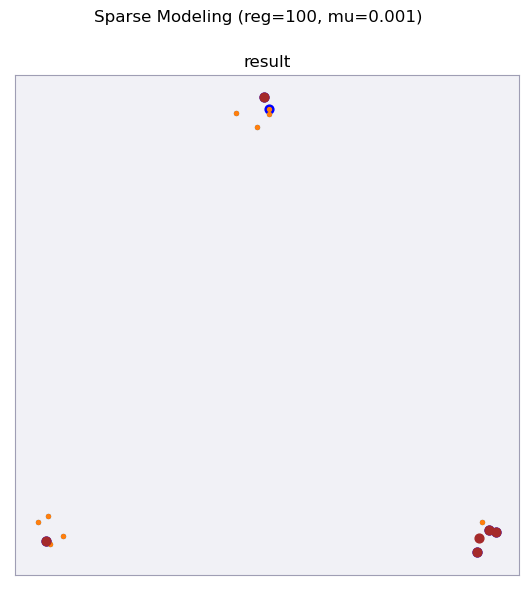

ADMM_time 80.50638270378113
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 11:33:30 AM: Your problem has 225 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 02 11:33:30 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 11:33:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 02 11:33:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 11:33:30 AM: Compiling problem (target solver=SCS).
(CVXPY) Aug 02 11:33:30 AM: Reduction chain: Dcp2Cone -> CvxAttr2Con

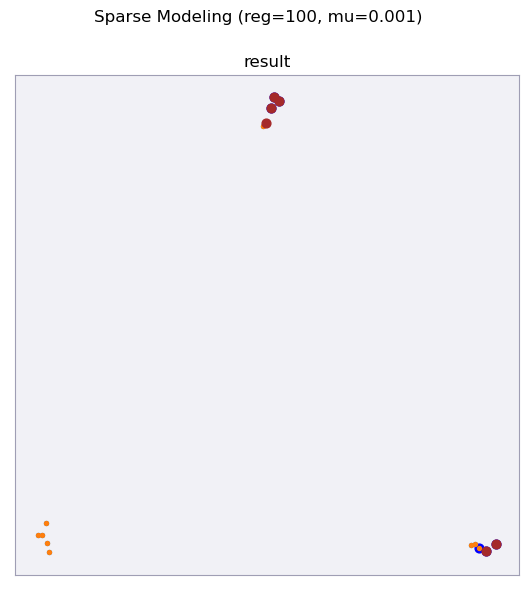

ADMM_time 81.06676936149597
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 11:34:52 AM: Your problem has 225 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 02 11:34:52 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 11:34:52 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 02 11:34:52 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 11:34:52 AM: Compiling problem (target solver=SCS).
(CVXPY) Aug 02 11:34:52 AM: Reduction chain: Dcp2Cone -> CvxAttr2Con

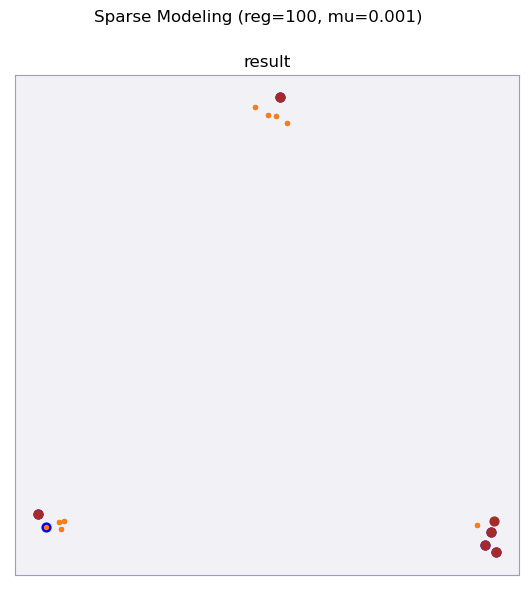

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.backends.backend_pdf import PdfPages
import time

def simple_scatterplot(ax, X, selected,color):
    ax.scatter(X[:,0], X[:,1], s=8)
    ax.scatter(X[selected,0], X[selected,1], s=40, c=color)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor((241/255, 241/255, 246/255))
    for spine in ax.spines.values(): spine.set_edgecolor((159/255, 158/255, 180/255))
for i in range(5):
    X1 = np.random.multivariate_normal([-2,0], [[0.01,0],[0,0.01]], 5)
    X2 = np.random.multivariate_normal([0,3.4], [[.01,0],[0,.01]], 5)
    X3 = np.random.multivariate_normal([2,0], [[.01,0],[0,.01]], 5)

    #X = np.array([[0,2,1,0,2,1,1,0,2],[0,0,1,2,2,0,2,1,1]]).T
    X = np.concatenate((X1, X2,X3), axis=0)
    #X=X1
    start1 = time.time()
    '''print("start1",start1)
    min_index,C_min=standard_test(X.T,4)
    print("end1",end1)'''
    end1 = time.time()
    #print("what",min_index)
    dist = euclidean_distances(X,X)

    SS = SubsetSelection(X, dist, 100)
    start2 = time.time()
    result6 = SS.ADMM_SparseModeling(0.001, 1e-4, 1e4)
    end2 = time.time()
    print("ADMM_time",end2-start2)
    start = time.time()
    result4, C = SS.ADMM_SparseModeling_bycvxpy(0.001,np.inf, False, 4,False)
    end = time.time()
    print("improved_time",end-start)

    result6 = result6['selected1']
    new_result4=result4['selected1']
    result4 = result4['selected']
    print(set(result6)==set(new_result4))
    fig, axes = plt.subplots(1, 1, figsize=(6.5,6.5))
        # Plot min_index on the first subplot
    simple_scatterplot(axes, X, result6, 'blue')
    axes.set_xticks([])
    axes.set_yticks([])

    # Plot result4 on the second subplot
    simple_scatterplot(axes, X, new_result4, 'brown')
    axes.set_title('result')
    axes.set_xticks([])
    axes.set_yticks([])
    # Set the title
    fig.suptitle(f'Sparse Modeling (reg={100}, mu={0.001})')
    # Save the figure to the PDF file
    plt.show()


## 对ADMM中C的更新进行求解，本质求优化问题||Y-YC||_F^2+||C-U||_F^2,进行10万次测试

In [ ]:
X = [[0,2,1,0,34,2,5],[0,0,1,2,2,6,7]]
dist =[]
admm=ADMM(1, 1e-5, 1e3,45)
#调用优化问题算法
result4 = admm.solverBCLS_varieties1(np.array(X),np.zeros((7,7)),1)
min_num=0.5*calculate_F2_norm(np.array(X)-np.array(X)@result4)+0.5*1*calculate_F2_norm(result4)
print(result4,min_num)
count=0
for i in range(100000):
    #给结果增加一个小偏差
    result= add_small_bias(result4, 0.005)
    test_num=0.5*calculate_F2_norm(np.array(X)-np.array(X)@result)+0.5*1*calculate_F2_norm(result)
    if test_num<min_num:
        count+=1
        #检查该解是否是最优解
        print(min_num<test_num,min_num,test_num)
print(count)

time1 0.005630016326904297
time2 0.003789186477661133
[[ 0.31975892  0.30633846  0.26065633  0.2149742  -0.01317347 -0.0080157
  -0.08053874]
 [ 0.30633846  0.29729313  0.24929513  0.20129713  0.04752649 -0.01783085
  -0.08391952]
 [ 0.26065633  0.24929513  0.22305085  0.19680655  0.00366625  0.05774579
   0.0087791 ]
 [ 0.2149742   0.20129713  0.19680655  0.19231595 -0.04019399  0.13332243
   0.10147773]
 [-0.01317347  0.04752649  0.00366625 -0.04019399  0.99170524 -0.03353509
   0.04400458]
 [-0.0080157  -0.01783085  0.05774579  0.13332243 -0.03353509  0.40618354
   0.4621299 ]
 [-0.08053874 -0.08391952  0.0087791   0.10147773  0.04400458  0.4621299
   0.548067  ]] 1.4891872682814724
0


In [ ]:
X = [[0,2,1,0,34,2,5],[0,0,1,2,2,6,7],[0,2,1,0,34,2,5],[0,2,1,9,34,2,5],[0,2,1,0,34,2,5],[0,2,1,80,34,2,5],[0,2,1,0,34,2,5]]
dist =[]
admm=ADMM(1, 1e-5, 1e3,1)
#lamda=1
l = np.ones((7, 1))
#测试该算法，norm=np.inf,lamda=1
#优化问题:lamda*||Z||_np.inf+0.5*||Z-X||_F^2
Z=admm.solverLpshrink(np.array(X),l,np.inf)
print(Z)
#计算该优化问题的最优解
norm=np.linalg.norm(Z, ord=np.inf)+0.5*calculate_F2_norm(Z-X)
#对最优解进行小偏移
count=0
for i in range(100000):
    Z1=add_small_bias(Z, 1)
    norm1=np.linalg.norm(Z1, ord=np.inf)+0.5*calculate_F2_norm(Z1-X)
    if norm1<norm:
        count+=1
        print(norm1,norm)
print(count)     

[[ 0.  2.  1.  0. 33.  2.  5.]
 [ 0.  0.  1.  2.  2.  6.  6.]
 [ 0.  2.  1.  0. 33.  2.  5.]
 [ 0.  2.  1.  9. 33.  2.  5.]
 [ 0.  2.  1.  0. 33.  2.  5.]
 [ 0.  2.  1. 79. 34.  2.  5.]
 [ 0.  2.  1.  0. 33.  2.  5.]]
0
